## Imports

In [5]:
import numpy as np
import pandas as pd

#!pip install pyEDFlib
import pyedflib
#!pip install ipympl

from scipy.fftpack import fft, ifft, fftfreq
from scipy import signal as sg
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
from scipy.stats import binned_statistic, entropy, norm
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import sys
import os
import time
#import pickle
import dill as pickle

import concurrent.futures
from numba import jit, njit, prange

from tqdm.notebook import tqdm
from collections import defaultdict
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import display
sns.set(context='notebook', style='ticks', palette='bright', font='sans-serif', font_scale=1, color_codes=True, rc=None)
plt.rcParams['figure.figsize'] = (10, 6)

#print("SYS.PATH: ", sys.path[:3])
#sys.path.insert(0, r"C:\Users\User\[[Python]]\[AlexeyT]\PAC_PROJECT")

from utility_functions import *
#from class_lfp import LFP
#from class_pac import MyPAC
#from class_patient import Patient
%run utility_functions.py
%run lfp_class.py
%run pac_class.py
%run patient_class.py

print("Succesfully imported libraries and modules\n")

Succesfully imported libraries and modules



## Time-frequency

In [6]:
def morlet_wavelet(freq, n_cycles, fs=256):
    ts       = np.arange(-1, 1 + 1/fs, 1/fs)
    s        = n_cycles / (2*np.pi*freq)
    sine     = np.exp(1j * 2*np.pi*freq * ts)
    gaussian = np.exp((-1) * (1/2) * (ts/s)**2)
    wavelet  = sine * gaussian
    return ts, wavelet


def tfr_morlet_wavelet(data, freqs, n_cycles_list=None, fs=256):
    """
    Computes time-frequency representation (n_freqs, n_times) using wavelet-transform (morlet wavelet convolution)
    """
    if n_cycles_list is None:
        n_cycles_list = np.ones(freqs.size) * 7 # default 7 cycles
        
    n_freqs, n_times = freqs.size, data.size
    tfr_data = np.zeros((n_freqs, n_times))
    
    for i_freq in range(n_freqs):
        _, wavelet = morlet_wavelet(freqs[i_freq], n_cycles_list[i_freq], fs)
        conv_result = signal.convolve(data, wavelet, 'same') 
        tfr_data[i_freq, :] = np.abs(conv_result) ** 2
        
    tfr_freqs = freqs
    tfr_times = np.arange(n_times) / fs
        
    return tfr_data, tfr_freqs, tfr_times
        


def plot_tfr(tfr_data, tfr_freqs, tfr_times, ax, title='TF-representation'):
    """Do not forget to adjust tfr_times to real times before executing. 
    This function assumes tfr_times are in SECONDS and begin from t_start sec"
    """
    
    x_min, x_max = tfr_times[0], tfr_times[-1]
    y_min, y_max = tfr_freqs[0], tfr_freqs[-1]
    
    ax.set_title(title)
    ax.imshow(tfr_data, 
               origin='lower', 
               cmap=plt.cm.jet, 
               aspect='auto', 
               interpolation='bilinear', 
               extent = [x_min , x_max, y_min , y_max])
    ax.set_xlabel("time, ms")
    ax.set_ylabel("freq, Hz")

In [7]:
freqs = np.logspace(np.log10(2), np.log10(450), 30)

tfr_data, tfr_freqs, tfr_times = tfr_morlet_wavelet(lfp.data, freqs, fs=2000)

cut_time = 2000 * 180

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plot_tfr(tfr_data[:, :cut_time], tfr_freqs, tfr_times[:cut_time], ax=axes)



NameError: name 'lfp' is not defined

In [83]:
freqs

array([4.93340967e+00, 7.58419103e+00, 1.16592696e+01, 1.79239378e+01,
       2.75546889e+01, 4.23601603e+01, 6.51207926e+01, 1.00110991e+02,
       1.53901851e+02, 2.36595198e+02, 3.63720692e+02, 5.59152269e+02,
       8.59591623e+02, 1.32146072e+03, 2.03149772e+03, 3.12304630e+03,
       4.80109728e+03, 7.38078558e+03, 1.13465720e+04, 1.74432239e+04,
       2.68156814e+04, 4.12240750e+04, 6.33742748e+04, 9.74260479e+04,
       1.49774255e+05, 2.30249795e+05, 3.53965826e+05, 5.44155994e+05,
       8.36537665e+05, 1.28601959e+06])

In [81]:
tfr_freqs

array([1.00000000e+002, 2.80721620e+017, 7.88046282e+032, 2.21221629e+048,
       6.21016942e+063, 1.74332882e+079, 4.89390092e+094, 1.37382380e+110,
       3.85662042e+125, 1.08263673e+141, 3.03919538e+156, 8.53167852e+171,
       2.39502662e+187, 6.72335754e+202, 1.88739182e+218, 5.29831691e+233,
       1.48735211e+249, 4.17531894e+264, 1.17210230e+280, 3.29034456e+295,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf])

In [9]:
with open("path_data.txt") as f:
    data_dir = f.readline()

p3_dir = os.path.join(data_dir, "Patient3")
print("Patient directory: ", p3_dir)
p3_pickle_filepath = os.path.join(p3_dir, "Patient3.pkl")

p3 = load_patient_from_pickle(p3_pickle_filepath)

p3.root_dir = p3_dir

p3.load_all_pacs(verbose=False)

condition = "5Day ON Rest 180sec"
placement = "L3A-3C"

lfp = p3.lfp[condition][placement]
pac = p3.pac[condition][placement][placement]

Patient directory:  D:\LAB\AlexPAC\data\Patient3


In [10]:
import mne

In [15]:
data = lfp.data.reshape((1, 1, -1))

freqs = np.arange(5, 50)
n_cycles = freqs/2

tfr_data = mne.time_frequency.tfr_array_morlet(data, 2000, freqs, output='power')[0, 0, :, :]

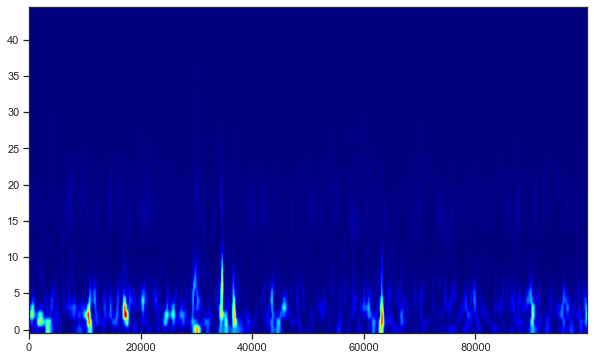

In [20]:
plt.imshow(tfr_data[:, 200000:300000], aspect='auto', origin='lower', cmap='jet')

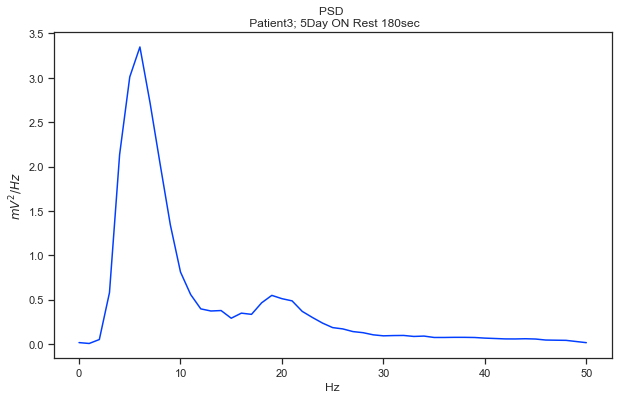

In [22]:
lfp.show_psd()